# Modeling with XGBoost

## 1. Preprocessing
- Lable-Encoding
- Log nomalization
- Standard scaling

# 2. Regressors 
- Cross-validation
- Feature Importance

# 3. Submission Score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import datetime
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('github'))))
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec
import utils.helpermodeling as hm
from scipy import stats
import xgboost as xgb

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import KFold, ParameterGrid, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.metrics import r2_score, explained_variance_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cv = KFold(n_splits=10, shuffle=True, random_state=1)

In [2]:
def show_results(y_test, pred, measured, preds):
    print('\n')
    print("Train Test Split")
    print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))

    print('\n')
    print("Cross Validation")
    print('RMSE:', np.sqrt(mean_squared_error(measured, preds)))

    fig  = plt.figure(figsize=(8, 4), dpi=100)
    axes1 = fig.add_subplot(121)
    axes1.scatter(y_test, pred, c='red', s=5)
    axes1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes1.set_title("Train Test Split")
    axes1.set_xlabel('Measured')
    axes1.set_ylabel('Predicted')
    axes2 = fig.add_subplot(122)
    axes2.scatter(measured, preds, c='red', s=5)
    axes2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes2.set_title("Cross Validation")
    axes2.set_xlabel('Measured')
    axes2.set_ylabel('Predicted')
    fig.tight_layout()
    
    fig  = plt.figure(figsize=(8, 4), dpi=100);
    axes1 = fig.add_subplot(121); 
    axes1.scatter(y_test, y_test-pred, c='red', s=2)
    axes1.set_title("Train Test Split")
    axes1.set_xlabel('Measured')
    axes1.set_ylabel('Residual')
    axes2 = fig.add_subplot(122); 
    axes2.scatter(measured, measured-preds, c='red', s=2)
    axes2.set_title("Cross Validation")
    axes2.set_xlabel('Measured')
    axes2.set_ylabel('Residual')
    fig.tight_layout();
    
    fig  = plt.figure(figsize=(8, 4), dpi=100)
    axes1 = fig.add_subplot(121)
    axes2 = fig.add_subplot(122)
    sns.distplot((y_test-pred), bins=50, ax=axes1, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "red"})
    sns.distplot((measured-preds), bins=50, ax=axes2, axlabel='Error Deviation', kde_kws={"color": "k", "lw": 1.5, "gridsize":1000}, hist_kws={"linewidth": 3, "alpha": 0.6, "color": "red"})
    axes1.set_title("Train Test Split")
    axes2.set_title("Cross Validation")
    axes1.set_xlim(-3, 3)
    axes2.set_xlim(-3, 3)
    

In [31]:
df_train = pd.read_csv('../input/train_macro_without_outliers.csv', index_col=0, parse_dates=['timestamp'])
df_test = pd.read_csv('../input/test_macro.csv', index_col=0, parse_dates=['timestamp'])

## 1. Preprocessing

In [4]:
print(df_train.shape)

(25000, 248)


In [5]:
cate_features = [
 'detention_facility_raion',
 'culture_objects_top_25',
 'railroad_1line',
 'big_market_raion',
 'incineration_raion',
 'big_road1_1line',
 'radiation_raion',
 'railroad_terminal_raion',
 'ecology',
 'thermal_power_plant_raion',
 'oil_chemistry_raion',
 'nuclear_reactor_raion',
 'product_type',
 'water_1line'
]

numeric_features = list(df_train.columns.drop(cate_features + ['price_doc'] + ['timestamp']).values)

### Lable-Encoding

In [41]:
for f in cate_features:
    df_train[f].fillna(df_train[f].value_counts().index[0], inplace=True)
    df_test[f].fillna(df_test[f].value_counts().index[0], inplace=True)
    
    lbl = LabelEncoder()
    lbl.fit(df_train[f].values)
    df_train[f] = lbl.transform(df_train[f].values)
    df_test[f] = lbl.transform(df_test[f].values)

### Log nomalizaion

In [42]:
# Log Normalization of Numeric Features
for column in numeric_features + ['price_doc']:
    if stats.skew(df_train[column].values) > 1:
        df_train[column] = np.log(df_train[column] + 1)  
        if column in df_test.columns.values:
            df_test[column]  = np.log(df_test[column] + 1)

### Standard scaling

In [43]:
# 평균 0 표준편차 1이 되도록 스케일링
train_scaler = StandardScaler()
train_scaler.fit(df_train[numeric_features])

scaled_numeric_train_X = train_scaler.transform(df_train[numeric_features])
df_scaled_numeric_train_X = pd.DataFrame(scaled_numeric_train_X, index=df_train.index, columns=numeric_features)
df_train = pd.concat([df_scaled_numeric_train_X, df_train[cate_features], df_train['price_doc']], axis=1)

scaled_numeric_test_X = train_scaler.transform(df_test[numeric_features])
df_scaled_numeric_test_X = pd.DataFrame(scaled_numeric_test_X, index=df_test.index, columns=numeric_features)
df_test = pd.concat([df_scaled_numeric_test_X, df_test[cate_features]], axis=1)

# 2. Regressors 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_train[numeric_features+cate_features], df_train['price_doc'], test_size=0.2, random_state=1)

xgr = xgb.XGBRegressor(nthread=-1, objective='reg:linear')

# Grid Search of Hyper-parameters
# param_grid = [{'max_depth': [3, 5, 10],
#                'learning_rate': [0.01, 0.1],
#                'n_estimators':  [50, 100, 200],
#                'colsample_bytree': [0.5, 1]
#               }]

param_grid = [{'max_depth': [10],
               'learning_rate': [0.1],
               'n_estimators':  [200],
               'colsample_bytree': [0.5]
              }]

grid_xgr = GridSearchCV(xgr, param_grid, cv=cv, n_jobs=4, verbose=1, scoring='neg_mean_squared_log_error')
grid_xgr.fit(X_train, y_train)
print(grid_xgr.best_estimator_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  2.1min finished


[00:37:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


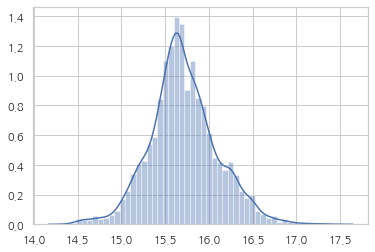

In [12]:
prediction = grid_xgr.best_estimator_.predict(X_test)
sns.distplot(prediction)

## Cross Validation and Results

[00:39:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:41:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

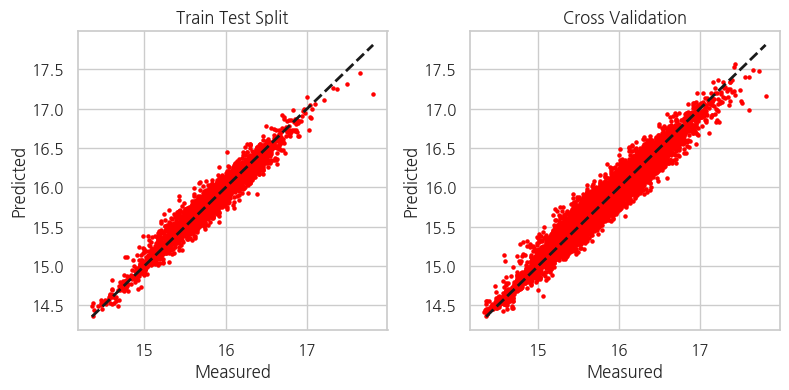

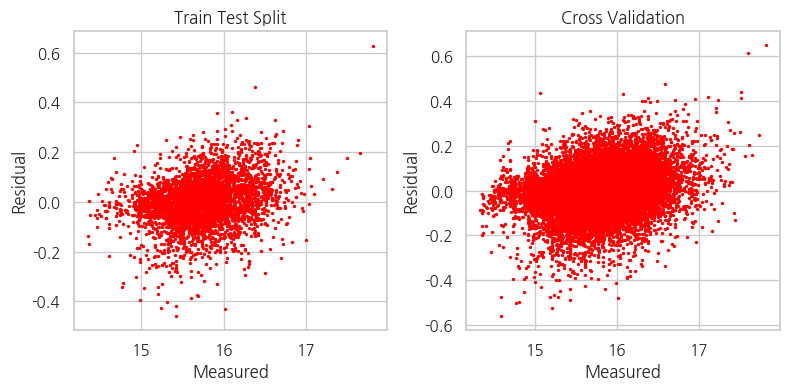

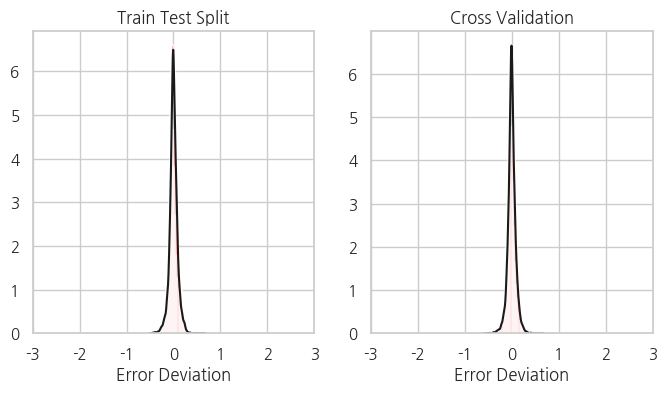

In [13]:
%%time

predictions = cross_val_predict(grid_xgr.best_estimator_, 
                                df_train[numeric_features+cate_features], 
                                df_train['price_doc'], 
                                cv=cv)

show_results(y_test, 
             prediction, 
             df_train['price_doc'], 
             predictions)

## Feature Importance

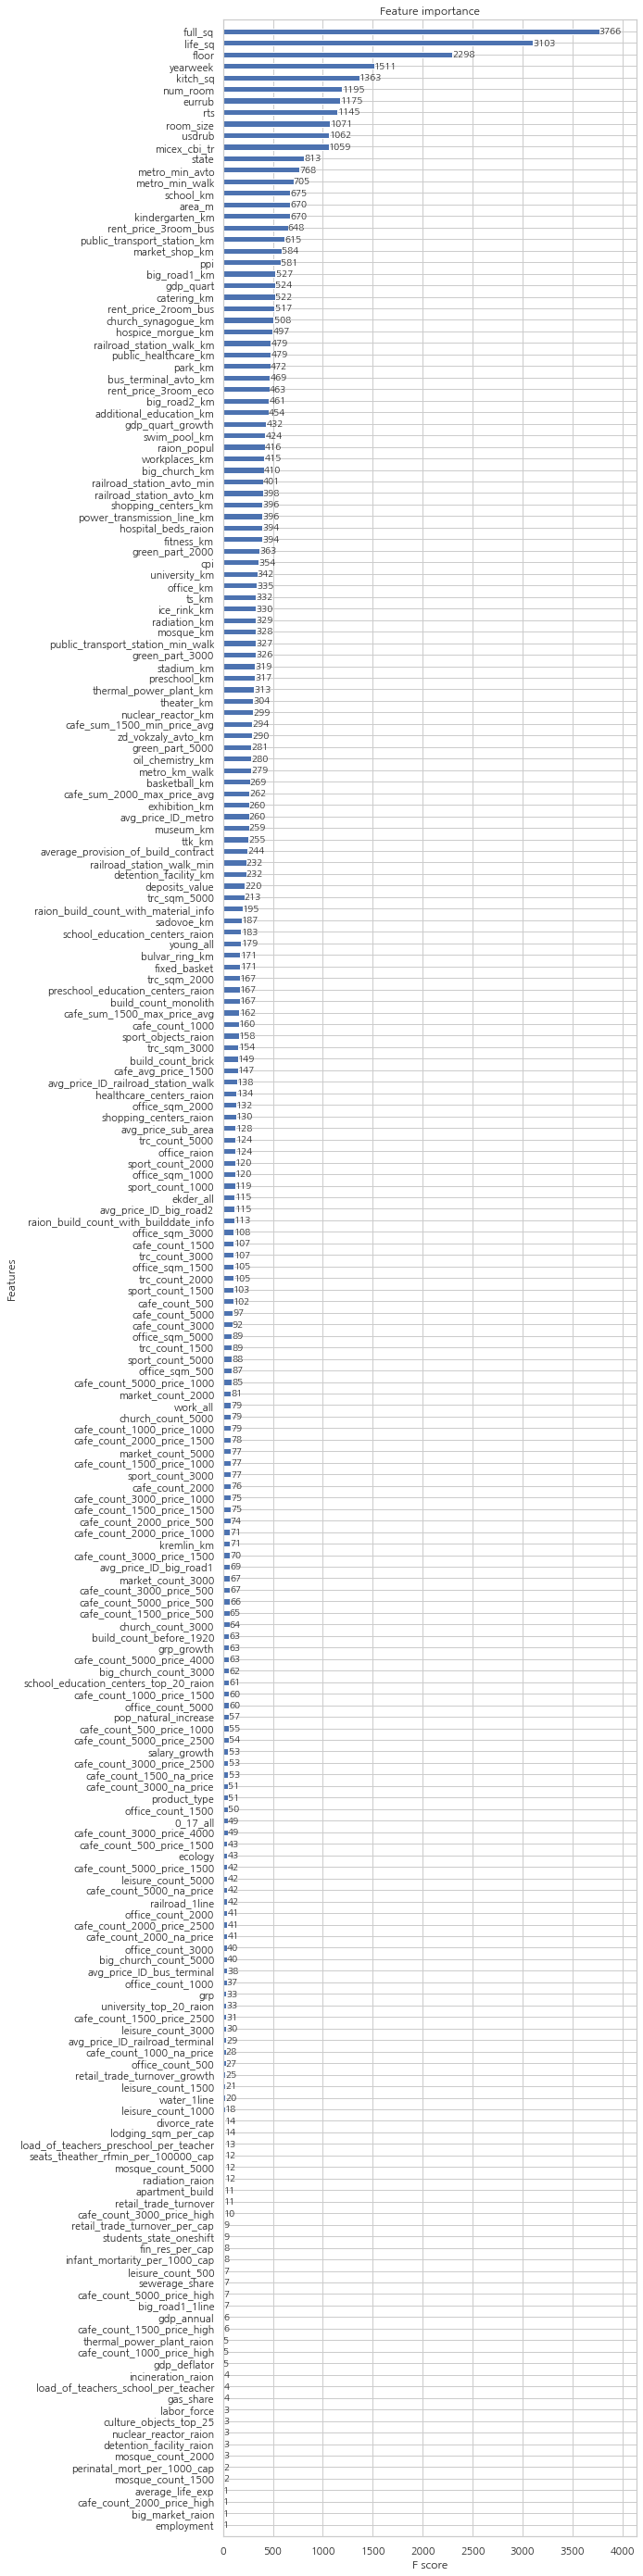

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 50))
xgb.plot_importance(grid_xgr.best_estimator_, height=0.5, ax=ax)

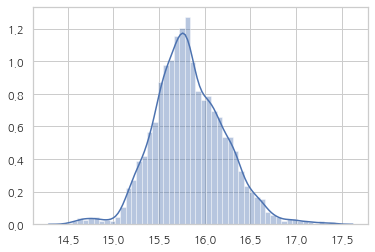

In [44]:
prediction = grid_xgr.best_estimator_.predict(df_test)
sns.distplot(prediction)

In [48]:
y_pred = np.exp(prediction)
df_pred= pd.DataFrame({'price_doc' : y_pred})
df_test1 = pd.read_csv('../input/test_macro.csv',  parse_dates=['timestamp'])
df1 = pd.concat([df_test1, df_pred], axis=1)
df2 = df1[['id', 'price_doc']]
df2.set_index('id', inplace=True)
df2.to_csv('../submissions/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

# Submission Score

0.34927 